# Calculating Eigenvalues  with Quantum Phase Estimation algorithm

In this demo we show how Quantum Phase Estimation algorithm can be used to calculate eigenvalues of a matrix.



## 1 Overview of Quantum Phase Estimation algorithm

Given a unitary operator $U$ with eigenvalues $e ^{2 \pi  i \phi}$ and eigenvectors $\left| u \right>$, QPE allows to find phase $\phi$. 

In order to do so, QPE requires 2 registers: 1 storing the input vector $\left| \psi \right>$, and 1 ancilla register that stores the $\phi$, as can be seen on the circuit schematic below.

The whole procedure is done in 3 steps:
1. The ancilla register is put in superposition by applying the H gates.
2. A series of U controlled rotations are applied on the $\left| \psi \right>$ register, which leave each kth ancilla qubit in state $\left| 0 \right> + e^{2 \pi i (2^{t-1})}\left| 1 \right> $
3. Inverse Fourier transform is applied on the ancilla register which leaves it in state $\left| \phi \right>$ that can be measured


<img src="images/Quantum_phase_estimation.png"  width="500 px" align="center">



## 2 Algorithm set up

This section explains step-by--step how the Quantum phase estimation algorithm is implemented in QISKit. 



### 2.1 Initiate
First we need to import the packages and initiate the program.

In [9]:
import sys
sys.path.append("..")

from qiskit_aqua.hhl.qpe import QPE
from demo_functions import *
import numpy as np
#from matrix_gen import gen_matrix
import matplotlib.pyplot as plt


### 2.2 Define the matrix
Now, we are ready to define the matrix, for example:

In [10]:
#matrix = gen_matrix(2, eigrange=[-4, 4], sparsity=0.6)  #random matrix
#or:
matrix = np.matrix([[-2, -1.5], [-1.5,2]])                     #your own

n = len(matrix)                                         #n is the size of the system

### 2.3 Define the input state vector

In this next step we choose the input vector. If the input vector happens to be an eigenvector the system gets into eigenstate, and as a consequence the outcome of the QPE is only a single eigenvalue (that corresponds to this eigenvector). 

In case it is desired to find all the eigenvalues, the system needs to be in a superposition of all the eigenstates - therefore the input vector shall be a combination of all the eigenvectors.

In [11]:
invec = ([0.3, 0.7])

### 2.4 Define the algorithm parameters
Finally we choose the backend and the algorithm parameters:

In [12]:
backend = "local_qasm_simulator"

k = 3
nege = True

params = {
    'algorithm': {
            'name': 'QPE',
            'num_ancillae': k,                   #Increase #of ancilla qubits - increase precision of eigenvalues
            'num_time_slices': 3,               #Increase # of time slices - improves accuracy of Hamiltonian simulation
            'expansion_mode': 'suzuki',          #Approximation method for matrix exponentiation
            'expansion_order': 2,                #Number of terms in aforementioned approximation of matrix exponentiation 
            'hermitian_matrix': True,
            'negative_evals': nege,              #Flag: are negative eigenvalues allowed ?
            'backend' : backend,
            #'evo_time': 2*np.pi/4,
            #'use_basis_gates': False,
    },
    "iqft": {
        "name": "STANDARD"
    },
    "initial_state": {
        "name": "CUSTOM",
        "state_vector": invec
    }
}

## 3 Results

In the next step the algorithm is executed and the final results are retrieved. In this case the results are in form of a histogram.

The results obtained with the quantum computing aproach are compared with the classical.  

### 3.1 Executing on a Local Simulator

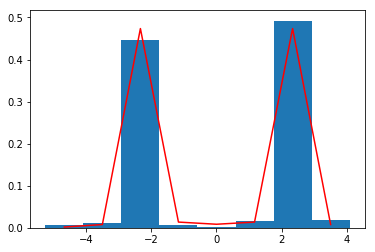

In [13]:
qpe = QPE()
qpe.init_params(params, matrix)
qc = qpe._compute_eigenvalue()
res = qpe._ret

plot_res_and_theory(res, matrix, k, nege)

In [14]:
w, v = np.linalg.eig(matrix)
print('Eigenvalues found with simulator:', Efr(res))
print('Eigenvalues found classically:', w.real.round(2))

Eigenvalues found with simulator: [ 2.33333333 -2.33333333]
Eigenvalues found classically: [-2.5  2.5]


### 3.2 Executing on a Quantum Computer

Now lets solve the same problem on an actual Quantum computer, and see how the results compare.

In [15]:
initiate_q_backend()

Qconfig loaded from /home/david/.local/lib/python3.7/site-packages/Qconfig.py.
['ibmq_qasm_simulator', 'ibmqx2', 'ibmqx4', 'ibmqx5', 'local_qasm_simulator', 'local_statevector_simulator', 'local_unitary_simulator']


In [16]:
k = 3
nege = True
params = {
    'algorithm': {
            'name': 'QPE',
            'num_ancillae': k,
            'num_time_slices': 3,
            'expansion_mode': 'suzuki',
            'expansion_order': 2,
            'hermitian_matrix': True,
            'negative_evals': nege,
            'backend' : 'ibmqx5',
            #'evo_time': 2*np.pi/4,
            #'use_basis_gates': False,
    },
    "iqft": {
        "name": "STANDARD"
    },
    "initial_state": {
        "name": "CUSTOM",
        "state_vector": invec#[1/2**0.5,1/2**0.5]
    }
}
# ibm_x5: max settings: for n = 2 k=3, suzuki, expansion order =2, -> max 3 time slices

In [ ]:
qpe = QPE()
qpe.init_params(params, matrix)
qc = qpe._compute_eigenvalue()
res_q = qpe._ret

plot_res_and_theory(res_q, matrix, k, nege)

## 3.3 Comparison of the results
You can see that the results from the actual Quantum computer are much more noisy - the peaks are not that sharp.

In [ ]:
#from demo_functions import Efr

print('Eigenvalues found with real device:', Efr(res_q))
print('Eigenvalues found with simulator:', Efr(res))
print('Eigenvalues found classically:', w.round(3))



plt.title('Local simulator')
plot_res_and_theory(res, matrix, k, nege)
plt.title('Real device')
plot_res_and_theory(res_q, matrix, k, nege)